##핸즈온머신러닝
###CH04. 모델 훈련



**4.1. 선형 회귀**

(1) 선형 모델
- 입력 특성의 가중치 합과 편향(절편)이라는 상수를 더하여 예측을 생성하는 모델
- 벡터 형태로 더욱 간단하게 나타낼 수 있음 -> 파라미터와 특성 벡터의 곱셈의 형태로 나타냄
- 선형 모델의 훈련
  - 모델을 훈련 = 모델이 훈련 세트에 가장 잘 맞도록 모델 파라미터를 설정하는 것
  - 모델을 훈련하기 전, 모델이 훈련 데이터에 얼마나 잘 맞는지 확인해야 함 -> RMSE가 최소화되는 theta를 찾아야 함(MSE가 최소화되는 theta 찾기)



4.1.1. 정규방정식
- 결과를 바로 얻을 수 있는 수학 공식으로, 비용함수를 최소화 하는 theta 값을 찾기 위한 해석적 방법
- 정규방정식 활용 예시

In [1]:
import numpy as np

X = 2*np.random.rand(100,1)
y = 4+3*X+np.random.randn(100,1)

In [2]:
# theta 계산하기
X_b = np.c_[np.ones((100,1)),X] # 모든 샘플에 x0=1을 추가합니다.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y) # inv(): 역행렬 계산, dot(): 행렬의 곱셈 계산

In [3]:
theta_best

array([[4.14800287],
       [2.92394532]])

-> 비슷하게 나타나나 잡음 때문에 원래 함수의 파라미터인 4와 3을 정확히 재현해내지 못함

In [4]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new] # 모든 샘플에 x0=1을 추가합니다.
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.14800287],
       [9.99589351]])

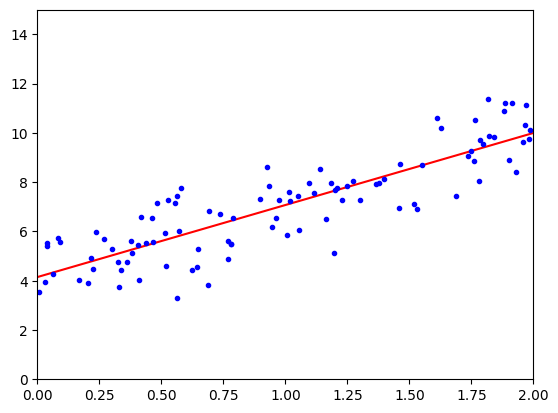

In [6]:
# 모델 예측을 그래프로 나타내기
import matplotlib.pyplot as plt
plt.plot(X_new, y_predict,"r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [7]:
# 사이킷런에서 선형 회귀 수행하기
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
lin_reg.intercept_,lin_reg.coef_

(array([4.14800287]), array([[2.92394532]]))

In [8]:
lin_reg.predict(X_new)

array([[4.14800287],
       [9.99589351]])

In [9]:
theta_best_svd, residuals, rank,s = np.linalg.lstsq(X_b, y, rcond=1e-6)  # scipy.linalg,lstsq(): 선형회귀를 수행해주는 함수
theta_best_svd

array([[4.14800287],
       [2.92394532]])

In [10]:
np.linalg.pinv(X_b).dot(y) # np.linalg.pinv(): 유사역행렬을 직접 구해주는 함수

array([[4.14800287],
       [2.92394532]])

유사역행렬 자체 = 특잇값 분해(SVD)의 표준 행렬 분해 기법을 사용하여 계산됨
- 즉, 정규방적식을 계산하는 것 보다 SUM을 먼저 구하고 낮은 임계값보다 작은 모든 수를 0으로 변환한 뒤, 0이 아닌 값을 모두 역수로 치환하여 행렬을 전치하는 방식이 더욱 효율적임
  - 정규 방정식의 경우 역행렬이 존재하지 않는다면 작동하지 않으나, 유사역행렬은 항상 작동하기 때문

4.1.2. 계산복잡도
- 역행렬을 계산하는 경우 이를 구하는 계산 시간도 늘어나게 됨
- 일반적으로 사이킷런 LinearRegression SVD 방법의 계산복잡도는 대략 $O(n^2)$정도임
  - 즉 특성의 수가 n개 늘어나면 이에 대한 계산시간은 $n^2$이 됨
  - 주의할 점은, 훈련 세트의 샘플 수에 대해서는 선형적으로 증가함
- 정규방적식이나 다른 알고리즘으로 학습된 선형 회귀 모델은 사이킷런에 비하여 예측이 매우 빠름
  - 예측 계산 복잡도가 샘플 수와 특성 수에 선형적으로 비례함
  


4.2. 경사 하강법
- 앞서 말했듯이, 특성이 매우 많고 훈련 샘플이 너무 많게 되면 메모리에 모두 담을 수 없고, 계산 복잡도가 올라가게 됨
- 따라서 경사하강법을 이용하여 최적의 해법을 찾게 됨
- 경사 하강법의 원리
  - 바용 함수를 최소화하기 위해 반복하여 파라미터를 조정해나가는 방법
  - 즉, 파라미터 벡터 theta에 대하여 비용 함수의 그래디언트를 계산하고, 이 그래디언트가 감소하는 방향으로 계산을 진행해나감 -> 그래디언트가 0이되면 최솟값에 도달했다고 간주
- 경사 하강법에서 중요한 파라미터는 **스텝의 크기(학습률)**임
  - 학습률이 너무 작으면 알고리즘에 수렴하기 위하여 반복을 많이 수행해야 하므로 시간이 오래걸림
  - 따라서 적당한 학습률을 설정하는 것이 중요함
- 경사 하강법의 문제점
  - 경사 하강법은 초기 theta에 대해 무작위 초기화를 진행하기 때문에 이 theta 값에 따라 전역 최솟값이 아닌 지역 최솟값에 수렴할 가능성이 존재함
    - 여기서 우리가 다루는 함수는 선형회귀이기 때문에 이러할 가능성은 존재하지 않음, 즉 함수가 볼록 함수로 형성되어 지역 최솟값이 존재하지 않음
  - 비용함수의 특성 스케일에 따라 최솟값에 도달하는 시간이 달라짐
    - 즉 비용 함수를 최소화하는 최적의 모델 파라미터 조합을 찾아야지만(적합한 모델 파라미터 공간을 찾아야지만) 빠른 시간 내에 최적의 결과를 도출할 수 있음
    

4.2.1. 배치 경사 하강법
- 경사 하강법을 구현하기 위해서는 각 모델ㄹ 파라미터 theta에 대해 비용함수의 그레디언트를 계산해야 함
- 즉, 이 theta가 변경될 때 어느정도로 비용함수가 바뀌는지를 계산해야 하는 것임 -> 이를 **편도함수**라고 함
- 편도 함수는 각각의 MSE(theta)를 구하는 방법으로, 각각의 theta에 대해 이를 미분하여 비용 함수의 편도함수를 구할 수 있음
  - 하지만 이 방법은 굉장히 번거롭기 때문에 그레디언트벡터를 이용하여 비용함수의 편도함수를 한꺼번에 구할 수 있음!
- 이렇게 구해진 그레디언트 벡털를 이용하여 원래의 theta에서 해당 그레디언트 벡터 만큼을 빼면서 과정을 진행함
- 배치 경사 하강법의 예시

In [11]:
eta = 0.1 # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # 무작위 초기화

for iteration in range(n_iterations):
  gradients= 2/m*X_b.T.dot(X_b.dot(theta)-y)
  theta = theta - eta*gradients

In [12]:
theta

array([[4.14800287],
       [2.92394532]])

=> 이는 앞서 정규방적식으로 찾은 theta와 동일함을 확인 가능
- 정리하면, 학습률이 너무 낮으면 알고리즘이 최적점에 도달하더라도 시간이 굉장히 오래걸리고, 학습률이 너무 높으면 알고리즘이 널뛰게 되면서 최적점에서 더욱 멀어져 발산할 수 있음 -> 즉 적절한 학습률을 찾는 것이 중요함!
- 적절한 학습률을 찾는 방법
- 적적한 학습률을 찾기 위해서는 그리드 탐색을 이용해야 함
- 그리드 탐색에서는 적절한 반복 횟수를 설정하는 것이 중요한데, 그 이유는 반복 횟수를 너무 크게 설정하게 되면 모델이 수렴하는데 시간이 너무 오래걸리기 때문!
- 적절한 반복 횟수를 설정하기 위해서는 반복 횟수를 먼저 아주 크게 지정한 뒤, 그레디언트 벡터가 허용오차보다 작아지면ㄴ 그 순간 알고리즘을 중지하는 방법을 사용하면 됨

4.2.2. 확률적 경사 하강법
- 앞서 말한 배치 경사 하강법은 매 스텝에서 전체 훈련 세트를 사용하여 그레디언트를 계산해야 하는 불편함이 존재함
  - 즉, 훈련 세트가 너무 커지면 수행하는데에 시간이 오래걸리게 됨
- 따라서 확률적 경사하강법을 이용하여 이러한 문제점을 해결함
- 확률적 경사하강법: 매 스템에서 한 개의 샘플을 무작위로 선ㄴ택한 후 그 하나의 샘플에 대한 그레디언트를 계산하는 방법
  - 매 반복에서 다뤄야 할 데이터가 매우 적기 때문에 한번에 하나의 샘플을 처리하게 되면 알고리즘을 더욱 빠르게 처리할 수 있음
  - 또한 매우 큰 훈련 세트에서도 매 반복에서 하나의 샘플만 메모리에 존재하면 되기 때문에 구현 가능
- 확률적 경사하강법의 단점
  - 이름에서도 알 수 있듯 확률적 경사하강법은 확률을 이용하기 때문에 배치 경사 하강법에 비하여 훨씬 불안전함
   - 비용함수가 최솟값에 다다를 때까지 안정적으로 감소하는 것이 아닌, 요동치며 감소하게 됨
   - 하지만 이렇게 요동치며 감소하기 때문에 지역 최솟값에 빠질 확률이 적어지게 됨!
   - 그래도 무작위성을 이용하기 때문에 결과적으로 전역 최솟값에 다다르지 못하는 경우도 종종 발생함 -> 이를 해결하기 위해 학습률을 점진적으로 감소시키는 방법을 활용함!
- 확률적 경사 하강법의 예시

In [14]:
n_epochs = 50
t0, t1 = 5, 50 # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
  return t0/(t+t1)

theta = np.random.randn(2,1)  # 무작위 초기화

for epoch in range(n_epochs): # epoch:반복을 의미
  for i in range(m):
    random_index = np.random.randint(m)
    xi = X_b[random_index:random_index+1]
    yi = y[random_index:random_index+1]
    gradients = 2*xi.T.dot(xi.dot(theta) - yi)
    eta = learning_schedule(epoch*m + i)
    theta = theta - eta*gradients

In [15]:
theta

array([[4.16721004],
       [2.94034284]])

사이킷런에서는 이 방식을 제곱 오차 비용 함수를 최적화 하는 SGDRegressor 클래스를 이용함

In [16]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [17]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.11233048]), array([2.92981238]))

4.2.3. 미니배치 경사 하강법
- 배치 경사 하강법과 마찬가지로 전체 훈련 세트나 하나의 샘플을 기반으로 그레디언트를 계산하는 것이 아닌 미니배치라 부르는 임의의 작은 샘플 세트에 대해 그레디언트를 계산하는 방식
- 확률적 경사 하강법에 비하여 미니배치 경사하강법은 행렬 연산에 최적화된 하드웨어인 GPU를 사용하여 성능향상을 얻을 수 있음
- 미니배치 경사 하강법은 결과적으로 SGD보다 최솟값에 더욱 가깝게 도달할 순 있으나, 지역 최솟값에서 빠질 확률이 높아지는 단점도 존재함
- 따라서 확률적 경사하강법과 미니배치 경사 하강법도 적절한 학습스케줄을 사용하는 것이 중요함!


4.3. 다항 회귀
- 가진 데이터가 단순한 직선이 아닌 비선형 데이터를 학습하는 경우, 다항 회귀를 이용하게 됨
- 다항회귀란, 각 특성의 거듭제곱을 새로운 특성으로 추가하고, 이 확장된 특성을 포함한 데이터셋에 선형 모델을 훈련 시키는 방법임
- 다항 회귀의 예시

In [19]:
m = 100
X = 6*np.random.rand(m,1)-3
y = 0.5*X**2 + X+ 2+np.random.randn(m,1)

In [26]:
# 다항회귀로 훈련 데이터 변환
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]


array([1.97203055])

In [27]:
X_poly[0]

array([1.97203055, 3.8889045 ])

In [28]:
# LinearRegression 적용
lin_reg = LinearRegression()
lin_reg.fit(X_poly,y)
lin_reg.intercept_, lin_reg.coef_

(array([2.31926092]), array([[1.00315791, 0.4947556 ]]))

4.4. 학습 곡선
- 고차 다항 회귀의 경우 보통의 선형회귀보다 훈련 데이터에 더욱 잘 맞추려 하는 경향이 있음 (그래프를 보면 다항 회귀 모델은 훈련 샘플에 가능한 가까이 가기위해 구불구불하게 나타나는 것을 확인 가능)
- 하지만 이런 경우, 고차 다항 회귀 모델은 훈련 데이터에 과적합 될 위험이 존재함
- 이렇게 과적합 유무를 알기 위해선 교차 검증을 이용할 수도 있으나, 여기선 학습 곡선을 살펴보는 방법도 있음
  - 학습곡선: 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기의 함수로 나타내어 이 모델의 학습 곡선을 그리는 함수
  - 학습 곡선의 예시

In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
  train_errors, val_errors = [], []
  for m in range(1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_val,y_val_predict))
  plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="훈련 세트")
  plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="검증 세트")

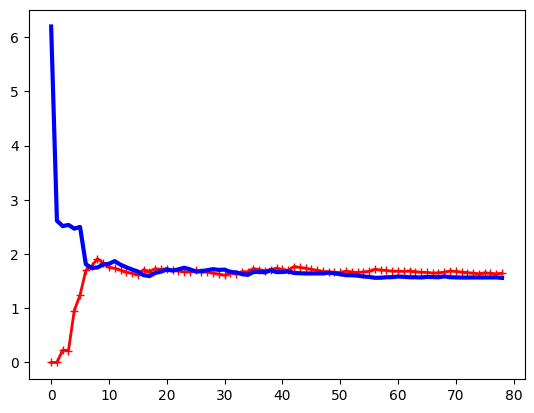

In [34]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

- 모델이 훈련 세트에 샘플이 추갇됨에 따라 검증 오차가 서서히 감소하는 것을 확인할 수 있음
- 10차 다항 회귀 모델의 학습 곡선 예시

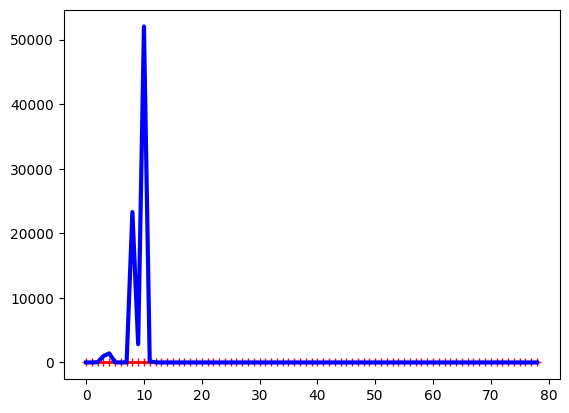

In [38]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)

두 학습 곡선의 차이
- 훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮음
- 두 곡선 사이에 공간이 존재함, 즉 훈련 데이터에서 모델 성능이 검증 데이터에서 보다 훨씬 낮다는 뜻이고, 이는 과데적합 모델의 특징임(하지만 더욱 큰 훈련 세ㅔ트를 사용하면 두 곡선이 점점 더 가까워 질 수 있음)

편향/분산 트레이드 오프
- 모델의 일반화 오차는 세 가지 다른 종류의 오차의 합으로 표현할 수 있음
  - 편향: 일반화 오차 중 편향은 잘못된 가정에 의한 것으로, 예를 듫어 데이터가 실제로 2차인데 선형으로 가정하는 경우를 의미함
  - 분산: 훈련 데이터에 있는 작은 변동에 모델이 과도하게 민감하여 나타난 겻으로, 자유도가 높은 모델이 높은 분산을 가지기 쉬워 훈련 데이터에 과대적합 되는 경우를 의미
  - 줄일 수 없는 오차: 데이터 자체에 있는 잡음으로, 이 오차를 줄이기 위해선 데이터에서 잡음을 제거해야 함

-> 모델의 복잡도가 커지면 통상적으로 분산은 늘어나고 편향은 줄어듦, 하지만 반대로 모델의 복잡도가 줄어들면 편향은 커지고 분산은 작아짐 (트레이드오프 현상)